<h1 style="text-align: center;" markdown="1">Machine Learning Algorithms for Poverty Prediction</h1> 
<h2 style="text-align: center;" markdown="2">A project of the World Bank's Knowledge for Change Program</h2>
<h3 style="text-align: center;" markdown="3">(KCP, Grant TF0A4534)</h3>


> *This notebook is part of a series that has been developed as an empirical comparative assessment of machine learning classification algorithms applied to poverty prediction. The objectives of this project are to explore how well machine learning algorithms perform when given the task to identify the poor in a given population, and to provide a resource of machine learning techniques for researchers, data scientists, and statisticians in developing countries.*

<h1 style="text-align: center;" markdown="3">Data Science Competition Results</h1> 
<h2 style="text-align: center;" markdown="3">Malawi Poverty Prediction</h2>

# Table of Contents
[Data Science Competition Results Introduction](#introduction)    
[Load Data and Define Functions to Read Results](#define)   
[Compare Top 3 Competitors and Bonus Winner](#compare)  
[Summary](#summary)

# Data Science Competition Results Introduction <a class="anchor" id="introduction"></a>

Data science competitions have a history of being used to solve particularly tricky predictive problems. One of the most well known predictive modeling competitions was the [Netflix Prize](https://www.netflixprize.com/), which offered \$1,000,000 USD to the team that could improve their recommendation algorithm by $10\%$. The competition ran from 2006 - 2009, and had participation from researchers around the world. Since then popularity of these kinds of competitions, known generally as innovation tournaments, has increased in commercial and academic spheres. These competitions offer prizes to teams or individuals who can solve a problem, the results of which are typically assessed by predictions on held-out subsets of the data. Online platforms such as [DrivenData](http://www.drivendata.org), engage data scientists and other quantitative experts from around the world in building models for a combination of prize money, recognition, practice, and real-world impact. These challenges enable participants to try out thousands of models for a given problem using whatever backgrounds, skills, and approaches they see fit, with the solutions that perform best (by predicting held-out data) climbing to the top of the leaderboard. These competitions offer the ability to explore new ways to provide broad coverage over a very wide search space of solutions.

[DrivenData, in partnership with The World Bank, hosted a data science competition](https://www.drivendata.org/competitions/50/worldbank-poverty-prediction/) where competitors were asked to optimize poverty prediction using survey data from three countries, Malawi, Tajikistan, and Namibia. The data was anonymized in order to minimize opportunities to use publicly available versions of the data that might exist. Aside from cash prizes for the top three leaderboard submissions, there was a bonus prize for the top competitor from a low-income or lower-middle-income country. 84 qualifying countries were determined using World Bank Country and Lending group data. 

<img alt="elig" src="img/parts.png" width=500/>

The competition ran from December 19, 2017 to February 28, 2018. The top 20 most represented competitor countries is shown in above. (Note: not all are eligible, and only about 400 actually specified their country.) There were just under 6,000 submissions to the competition coming from approximately 30 percent of the participants who entered, as reported below. Ultimately, the winner of this bonus prize was in 5th place on the private leaderboard at the end of the competition.

<img alt="leader" src="img/wb-poverty-leaderboard.png" width=500/>

First, let's import the standard libraries we'll need.

In [1]:
%matplotlib inline

import os
import sys
import json
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()

# Add our local functions to the path
sys.path.append(os.path.join(os.pardir, 'src'))
from models.evaluation import evaluate_model
from visualization import visualize
from data.load_data import (get_country_filepaths, 
                            split_features_labels_weights, 
                            load_data)
from features.process_features import get_vif, standardize
from features.process_features import MWI_BASIC_FEATURES

ALGORITHM_NAME = 'competition'
COUNTRY = 'mwi-competition'
TRAIN_PATH, TEST_PATH, QUESTIONS_PATH = get_country_filepaths(COUNTRY)

Using TensorFlow backend.


# Load Data and Define Functions to Read Results <a class="anchor" id="define"></a>

We will compare the top 3 and bonus submissions on the private subset of the competition data. this ensures that the results are not overfit to the leaderboard. In other words, the figures are generated using a different subset of the Malawi data than that of the models in the earlier part of the project. Specifically, in the case of the competition there exists a private subset of test data. The public-facing leaderboard score is calculated using _only_ test data that do _not_ belong to this private subset. The private subset is used to calculate a "private leaderboard" score. Competitors do not know which test data belong to the private subset. If they did, then a sequence of leaderboard scores could be used determine the true labels using only the performance metric, e.g., logloss, and no predictive modeling. The private leaderboard is used to determine the competition winner. However, if the private subset class samples are representative and the models do not overfit the public data, then the difference between the public and private leaderboard scores should be small. The data in usd in this notebook were generated using the private subset of test data from the competition in order to minimize any effects of overfitting the leaderboard. The data in in the rest of the project on the other hand, were generated using the train-test-split of Malawi data used in the other notebooks. Both samples are representative however, therefore these results suggest that competitions compare well with a more systematic comprehensive search of the exploration of possible models.

We only include the winners' predictions in this notebook, but all of the code for the winning submissions is available in the [DrivenData Competition Winners Repository](https://github.com/drivendataorg/competition-winners/).

The winners results files:

In [2]:
competition_path = Path('..', 'data', 'raw', 'competition-winners')
list(competition_path.iterdir())

[PosixPath('../data/raw/competition-winners/just_pubidx.csv'),
 PosixPath('../data/raw/competition-winners/3rd-lastrocky.csv'),
 PosixPath('../data/raw/competition-winners/2nd-sagol.csv'),
 PosixPath('../data/raw/competition-winners/1st-rgama-ag100.csv'),
 PosixPath('../data/raw/competition-winners/bonus-avsolatorio.csv'),
 PosixPath('../data/raw/competition-winners/just_labels.csv')]

The private test data from the competition

In [3]:
y_test = pd.read_csv(competition_path / 'just_labels.csv', index_col='id')
pub_idx = pd.read_csv(competition_path / 'just_pubidx.csv', index_col='id')
y_test = y_test[~pub_idx.PUBSUBIDX]

A map and function to pick out the correct country

In [4]:
y_prob = {'1st': pd.read_csv(competition_path / '1st-rgama-ag100.csv', index_col='id'), 
          '2nd': pd.read_csv(competition_path / '2nd-sagol.csv', index_col='id'), 
          '3rd': pd.read_csv(competition_path / '3rd-lastrocky.csv', index_col='id'), 
          'Bonus': pd.read_csv(competition_path / 'bonus-avsolatorio.csv', index_col='id')}

def reduce_to_country(country, y_test, y_prob):
    allowed_countries = ['A', 'B', 'C']
    if country not in allowed_countries:
        raise ValueError(f"Country must be {allowed_countries}") 
    
    reduced_idx = y_test[y_test.country == country].index
    reduced = {'y_test': y_test.loc[reduced_idx].poor.astype(int),
               'y_prob': {key: df.loc[reduced_idx].poor for key,df in y_prob.items()},
               'y_pred': {key: (df.loc[reduced_idx] > 0.5).poor.astype(int) for key,df in y_prob.items()}}
    return reduced

Finally, we'll write a function that generates the comparison for us. It will print the individual ROC curves for each competitor, along with a single plot that compares all of the competitors we're looking at (top 3 plus bonus winner).

In [5]:
def compare_winners(country, y_test, y_prob):
    countries = {'A': 'mwi', 'B': 'tjk', 'C': 'nmb'}
    places = ['1st', '2nd', '3rd', 'Bonus']
    data = reduce_to_country(country, y_test, y_prob)
    
    # generate and save individual
    for place in places:
        metrics = evaluate_model(data['y_test'], 
                                 data['y_pred'][place], 
                                 data['y_prob'][place], 
                                 model_name=f"{countries[country]}_{place}",
                                 prefix=ALGORITHM_NAME,
                                 country=COUNTRY,
                                 predict_pov_rate=False,
                                 store_model=True)
        
    # compare all
    metrics = evaluate_model(data['y_test'], 
                             data['y_pred']['1st'], 
                             data['y_prob']['1st'], 
                             model_name=f"{countries[country]}_{'1st'}",
                             compare_models=[f"{ALGORITHM_NAME}_{countries[country]}_{place}" for place in places if place != '1st'],
                             prefix=ALGORITHM_NAME,
                             country=COUNTRY,
                             predict_pov_rate=False,
                             store_model=True)

# Compare Top 3 Competitors and Bonus Winner <a class="anchor" id="compare"></a>

## Malawi

Check country class balance to make sure this is a representative sample

In [6]:
y_test[y_test.country == 'A'].poor.value_counts(normalize=True)

0.0    0.548604
1.0    0.451396
Name: poor, dtype: float64

### Run the comparison

/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


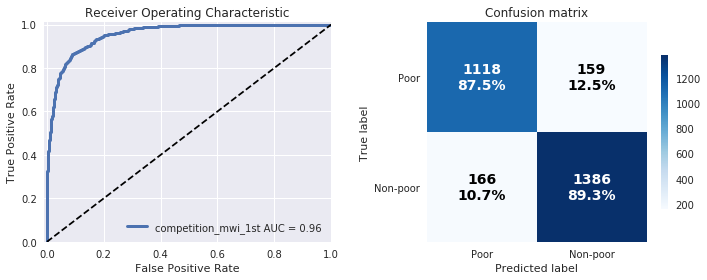

,competition_mwi_1st
accuracy,0.885118
recall,0.875489
precision,0.870717
f1,0.873096
cross_entropy,0.264241
roc_auc,0.957055
cohen_kappa,0.768158


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


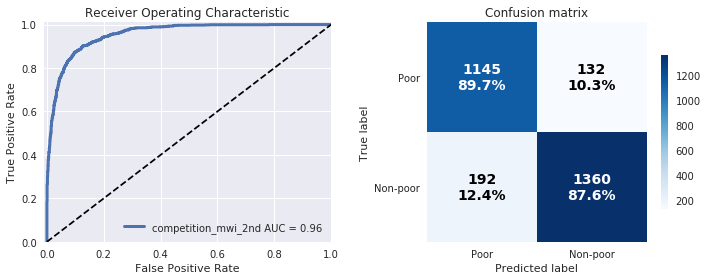

,competition_mwi_2nd
accuracy,0.885472
recall,0.896633
precision,0.856395
f1,0.876052
cross_entropy,0.268539
roc_auc,0.95562
cohen_kappa,0.769717


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


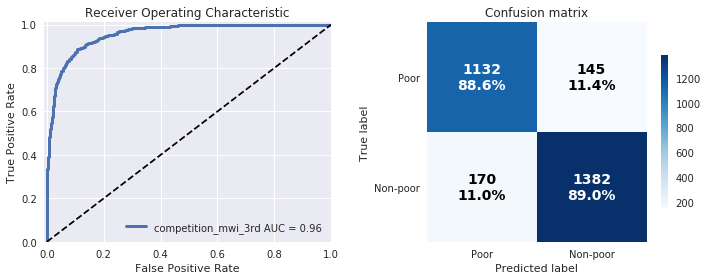

,competition_mwi_3rd
accuracy,0.888653
recall,0.886453
precision,0.869432
f1,0.87786
cross_entropy,0.262313
roc_auc,0.957455
cohen_kappa,0.775571


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


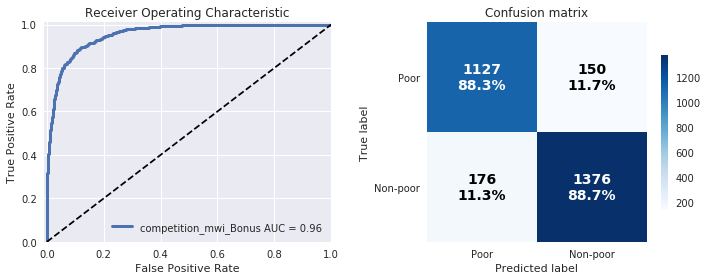

,competition_mwi_Bonus
accuracy,0.884765
recall,0.882537
precision,0.864927
f1,0.873643
cross_entropy,0.264155
roc_auc,0.956815
cohen_kappa,0.76775


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


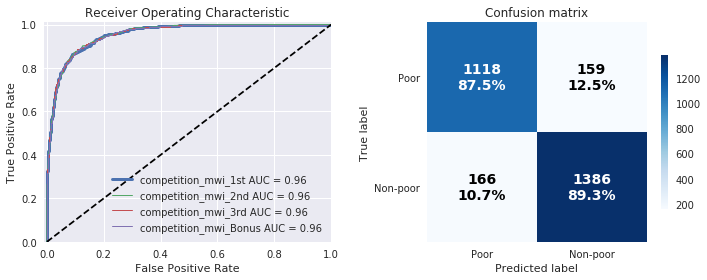

,competition_mwi_1st,competition_mwi_2nd,competition_mwi_3rd,competition_mwi_Bonus
accuracy,0.885118,0.885472,0.888653,0.884765
recall,0.875489,0.896633,0.886453,0.882537
precision,0.870717,0.856395,0.869432,0.864927
f1,0.873096,0.876052,0.87786,0.873643
cross_entropy,0.264241,0.268539,0.262313,0.264155
roc_auc,0.957055,0.95562,0.957455,0.956815
cohen_kappa,0.768158,0.769717,0.775571,0.76775


In [7]:
compare_winners('A', y_test, y_prob)

Interestingly, when looking at just the balanced Malawi data, the top competitors' submissions produce results that are slightly better than the initial survey of methods on the Malawi data explored in the first part of this project.

Noteably, the first place winner has the best recall.

# Summary <a class="anchor" id="summary"></a>

The winners of the competition came from all over the world: Portugal, Russia, Germany, and The Phillipines. The competitors all used ensembles of different algorithms, and every ensemble included tree-based methods. The most popular model is an implementation of gradient boosted trees called [`LightGBM`](https://github.com/Microsoft/LightGBM), which appeared in all of the four solutions that were awarded prizes. Three of the 4 prize winners used both XGBoost and some form of artificial neural network. Finally, [`CatBoost`](https://github.com/catboost/catboost), a method of gradient boosting developed at the Russian search engine company Yandex, and random forests appeared in one solution each. Most of the winners chose a simple blending approach to ensembling model predictions, which consists of a weighted combination of the predictions of each model.

These results indicate that across household survey datasets which contain mostly categorical features, tree based models can be the most effect. They also demonstrate that ensembling can be a useful tool for getting the most predictive power out of a dataset without overfitting. This is consistent with with the esembling results we've seen in other notebooks.


<hr/>

<div class="nostyle" style="width:100%">
<div style="width: 32%; float: left;">
    <a href="https://www.drivendata.org"><img src="https://s3.amazonaws.com/drivendata-public-assets/logo-white-blue.png"/></a>
</div>
<div style="width: 65%; float: right;">
    <p>These materials have been produced by the team at <a href="https://www.drivendata.org">DrivenData</a>, which uses data science, machine learning, and AI for social impact all around the world. DrivenData runs <a href="http://www.drivendata.org/competitions/">machine learning competitions</a> and provides <a href="http://drivendata.co/">data science services</a> to non-profits, NGOs, and governments. If you care about using data to change the world, get in touch!</p>
</div>
</div>

<hr/>